# 作業 : (Kaggle)鐵達尼生存預測
***
https://www.kaggle.com/c/titanic

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

data_path = 'data/'
df = pd.read_csv(data_path + 'titanic_train.csv')

train_Y = df['Survived']
df = df.drop(['PassengerId'] , axis=1)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# 記得刪除 Survived
df = df.drop(['Survived'] , axis=1)
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
def category_data(data):
    num_features = []
    object_features = []
    for dtype, feature in zip(data.dtypes, data.columns):
        if dtype == 'float64' or dtype == 'int64':
            num_features.append(feature)
        if dtype == 'object':
            object_features.append(feature)
    return(num_features,object_features)
    print(f'{len(num_features)} Numeric Features : {num_features}\n')
    print(f'{len(object_features)} Numeric Features : {object_features}\n')
    print(f'{df.shape[1]} Total Features')

# 削減文字型欄位, 只剩數值型欄位
df = df[category_data(df)[0]]
df = df.fillna(-1.0)
df=df.astype('float')
MMEncoder = MinMaxScaler()
df.head()

,Pclass,Age,SibSp,Parch,Fare
0,3.0,22.0,1.0,0.0,7.2500
1,1.0,38.0,1.0,0.0,71.2833
2,3.0,26.0,0.0,0.0,7.9250
3,1.0,35.0,1.0,0.0,53.1000
4,3.0,35.0,0.0,0.0,8.0500


In [ ]:
# 記得刪除 Survived
df = df.drop(['Survived'] , axis=1)

#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
df.head()

# 作業1
* 鐵達尼生存率預測中，試著變更兩種以上的相關係數門檻值，觀察預測能力是否提升?

In [3]:
# 原始特徵 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df)
estimator = LogisticRegression(solver='lbfgs')
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.7004864906462793

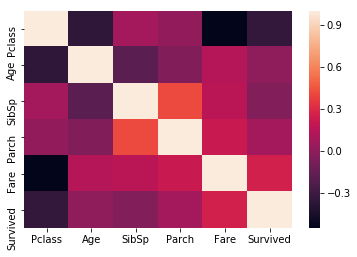

In [4]:
df = pd.merge(df, train_Y.to_frame(),left_index=True, right_index=True)
# 計算df整體相關係數, 並繪製成熱圖
import seaborn as sns
import matplotlib.pyplot as plt
corr = df.corr()
sns.heatmap(corr)
plt.show()

In [5]:
# 篩選相關係數1
high_list = list(corr[(corr['Survived']>0.3) | (corr['Survived']<-0.3)].index)
print(high_list)
high_list.pop(-1)
print(high_list)

['Pclass', 'Survived']
['Pclass']


In [6]:
# 特徵1 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df[high_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6791567235397566

In [7]:
# 篩選相關係數2
high_list = list(corr[(corr['Survived']>0.1) | (corr['Survived']<-0.1)].index)
print(high_list)
high_list.pop(-1)
print(high_list)

['Pclass', 'Fare', 'Survived']
['Pclass', 'Fare']


In [8]:
# 特徵2 + 邏輯斯迴歸
train_X = MMEncoder.fit_transform(df[high_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6791567235397566

# 作業2
* 續上題，使用 L1 Embedding 做特徵選擇(自訂門檻)，觀察預測能力是否提升?

In [9]:
df = df.drop(['Survived'] , axis=1)
from sklearn.linear_model import Lasso
L1_Reg = Lasso(alpha=0.006)
train_X = MMEncoder.fit_transform(df)
L1_Reg.fit(train_X, train_Y)
L1_Reg.coef_

array([-0.38017261, -0.10828614, -0.        ,  0.        ,  0.        ])

In [10]:
L1_list=df.columns[list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))].tolist()
# L1_Embedding 特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df[L1_list])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.6870410779253894